In [0]:
import zipfile
local_zip = '/house-prices-advanced-regression-techniques.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/house_prices')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
df = pd.read_csv('/tmp/house_prices/train.csv')
df.shape

(1460, 81)

In [0]:
#We have 1460 entries and 81 attributes/features

In [4]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)[:20]


PoolQC         0.995
MiscFeature    0.963
Alley          0.938
Fence          0.808
FireplaceQu    0.473
LotFrontage    0.177
GarageCond     0.055
GarageType     0.055
GarageYrBlt    0.055
GarageFinish   0.055
GarageQual     0.055
BsmtExposure   0.026
BsmtFinType2   0.026
BsmtFinType1   0.025
BsmtCond       0.025
BsmtQual       0.025
MasVnrArea     0.005
MasVnrType     0.005
Electrical     0.001
Utilities      0.000
dtype: float64

In [0]:
#Out of the 81 attributes,4 have more than 80% missing values


In [0]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis=1, inplace=True)


In [6]:
df.head(10)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.000,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,nan,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.000,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000



 mu = 180921.20 and sigma = 79415.29



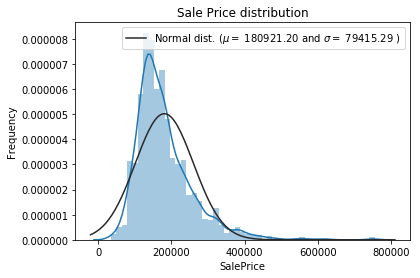

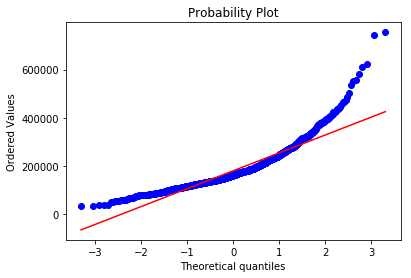

In [7]:
#Exploring Data
sns.distplot(df['SalePrice'] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')
#QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show();

In [0]:
#salesprice is right skewed.
#transforming salesprice


 mu = 12.02 and sigma = 0.40



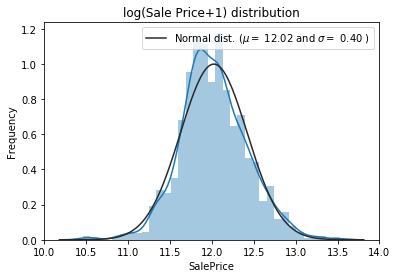

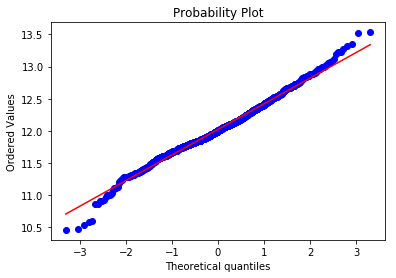

In [9]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))  #log1p will return the natural log of 1+ array (elementwise)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')
#QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

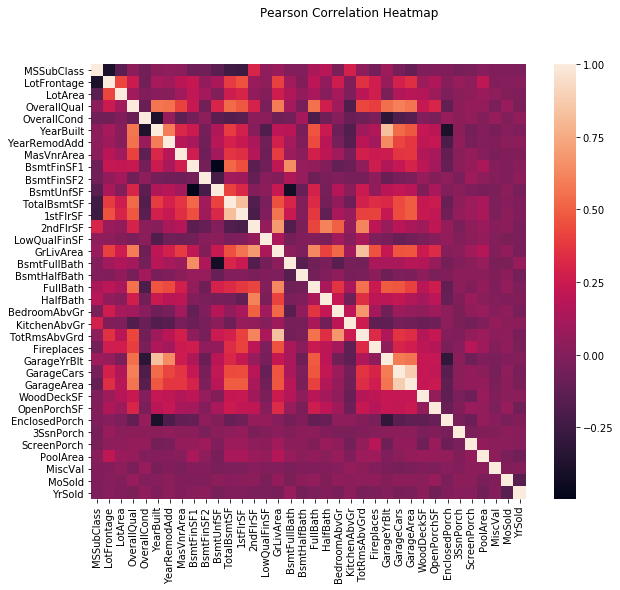

In [10]:
#correlation among features
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

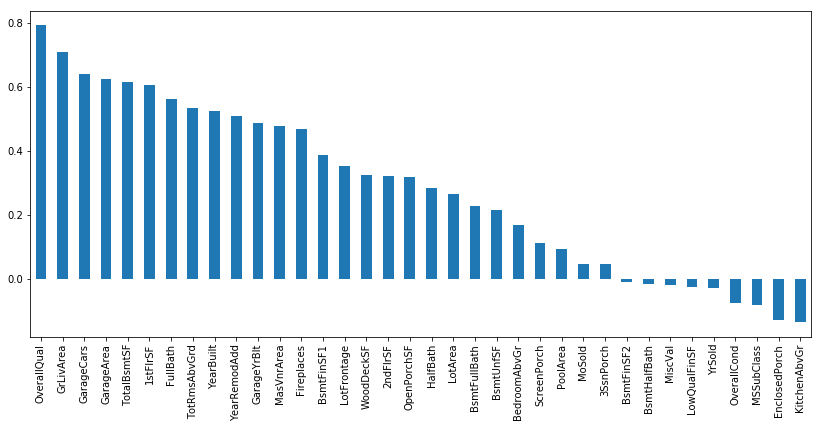

In [14]:
#Correlation of SalePrice with features
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();

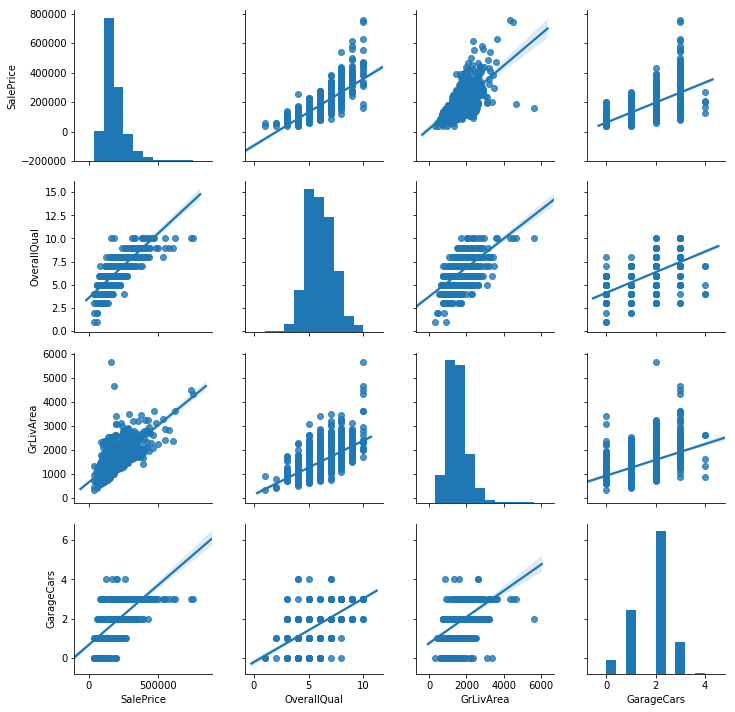

In [15]:
#correlation of SalePrice is greatest with OverallQual,GrLivArea,GarageCares

sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']],kind="reg")
plt.show();

In [0]:
df["SalePrice"] = np.log1p(df["SalePrice"])

#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])
df = pd.get_dummies(df)
df = df.fillna(df.mean())

X, y = df.drop(['SalePrice'], axis = 1), df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [17]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)
               
cv_model.fit(X_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00013634
Optimal l1_ratio: 0.700
Number of iterations 84


In [18]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)


Train r2 score:  0.9352316018794962
Test r2 score:  0.8300355301028953
Train RMSE: 0.0963
Test RMSE: 0.1604


113 features, reduction of 58.91%


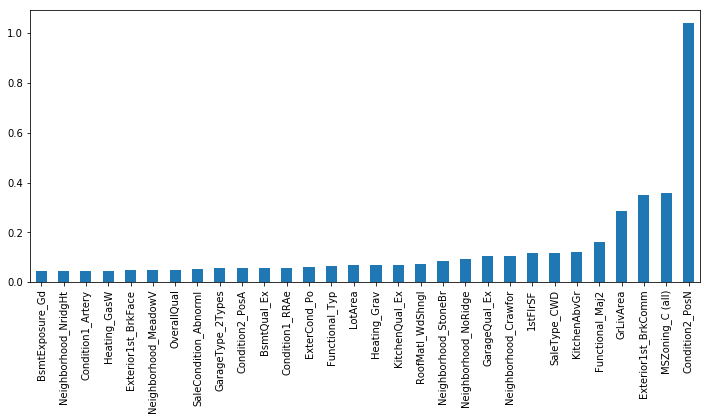

In [19]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))
n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))
feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

In [0]:
#XGBoost model .  #default parameters

In [22]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

[07:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9546691336034475
Test r2 score:  0.8856612816972917
Train RMSE: 0.0820
Test RMSE: 0.1316


In [0]:
#better than elasticNetCV

In [24]:
xgb_model2 = XGBRegressor(n_estimators=1000)         #adding parameters to the model
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

[07:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9678837547788781
Test r2 score:  0.8931330796873692
Train RMSE: 0.0699
Test RMSE: 0.1272


In [25]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)      #adding learning rate
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

[07:31:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9479569687487649
Test r2 score:  0.8840040768045745
Train RMSE: 0.0869
Test RMSE: 0.1325


In [0]:
#no improvement..model 2 is the best one

In [27]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 68),
             ('GrLivArea', 64),
             ('OverallQual', 56),
             ('TotalBsmtSF', 45),
             ('OverallCond', 45),
             ('GarageYrBlt', 33),
             ('BsmtUnfSF', 30),
             ('LotFrontage', 29),
             ('YearRemodAdd', 27),
             ('BsmtFinSF1', 26),
             ('YearBuilt', 24),
             ('MSSubClass', 24),
             ('GarageArea', 23),
             ('MoSold', 20),
             ('2ndFlrSF', 19),
             ('1stFlrSF', 18),
             ('OpenPorchSF', 17),
             ('MSZoning_C (all)', 16),
             ('EnclosedPorch', 15),
             ('Functional_Typ', 14),
             ('SaleCondition_Abnorml', 13),
             ('Condition1_Norm', 12),
             ('WoodDeckSF', 11),
             ('Neighborhood_Crawfor', 11),
             ('ScreenPorch', 11),
             ('PoolArea', 11),
             ('MasVnrArea', 10),
             ('KitchenAbvGr', 8),
             ('Condition1_Artery', 8),
    

In [0]:
#4 most important features selected are: 'LotArea','GrLivArea','OverallQual','TotalBsmtSF'

In [30]:
most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
train_x=df[most_relevant_features]
train_y=df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

[07:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9585238274804593
Test r2 score:  0.8950051742272032
Train RMSE: 0.0787
Test RMSE: 0.1261


In [0]:
#small improvement